In [1]:
import time
import numpy as np
import cv2
import torch

from utils.datasets import letterbox
from utils.models import *
from Utils_orientation import *

# Image path
base_file = 'Video/' + str(71) + '.jpg'
rotate_file = 'Video/' + str(99) + '.jpg'

# Configuration file path
cfg = 'cfg/yolov3.cfg'
data_cfg = 'cfg/coco.data'
weights = 'cfg/yolov3.pt'

# Model parameter
img_size=640
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Initialize model and load weights
model = Darknet(cfg, img_size)
model.load_state_dict(torch.load(weights, map_location=device)['model'])
model.to(device).eval()

# Detection Process Transform tensor into numpy array
if device == torch.device("cpu"):
    detection_base = object_detection(model, base_file).numpy()
    detection_rotate = object_detection(model, rotate_file).numpy()
else:
    detection_base = object_detection(model, base_file).cpu().numpy()
    detection_rotate = object_detection(model, rotate_file).cpu().numpy()
    
# Image Orientation Calculation
show_results = True
show_images = True
mode = "SIFT"
# The index of object using to calculation the capture image
detection_index = 2

In [8]:
for i in range(700):
    img_file = 'Video/' + str(i) + '.jpg'
    detection = object_detection(model, img_file).cpu().numpy()
    if detection.shape[0] == 4:
        print("The {0:3d} image is detected ".format(i))
        print(detection)

The  20 image is detected 
[[     118.07      64.453      433.97      358.22     0.80383     0.88729          63]
 [     441.52       9.186      640.52      336.22      0.6078     0.74558          56]
 [     434.27      267.33      635.59      358.31     0.53903     0.85025           0]
 [     446.77       8.072      636.28      269.42     0.50641     0.53064          24]]
The  21 image is detected 
[[      118.2      60.376      433.09       359.1      0.7557     0.84542          63]
 [     434.28      265.95      635.72      358.91     0.66397     0.89257           0]
 [     441.64       7.826      640.47      337.36     0.63689     0.77057          56]
 [     447.32      7.5496      635.86      269.45     0.53612     0.55823          24]]
The  23 image is detected 
[[     119.02      67.315      432.09      359.54     0.82901     0.92577          63]
 [     440.84      11.387      641.96      333.66     0.66687     0.81803          56]
 [     433.81      265.84      636.83      358.

 [     114.24      18.863      449.17      353.89     0.53449     0.98121          63]]
The  72 image is detected 
[[     210.15      33.837      258.64      84.572     0.81682     0.98845          64]
 [     421.96       1.966       639.1      189.22       0.712     0.78413          24]
 [     463.66      230.09      642.77      351.26     0.66948     0.97575           0]
 [     240.43      132.68      404.25      298.61     0.50947     0.95024          66]]
The  73 image is detected 
[[     420.26      1.6309      639.35      187.98     0.75662     0.81022          24]
 [     209.75      35.675      258.62      85.216     0.71425     0.98714          64]
 [     462.12      230.26      641.49      351.25     0.70897     0.97582           0]
 [     193.53      42.082      441.35      340.15      0.5213     0.98168          63]]
The  83 image is detected 
[[     471.98      221.11      640.47      350.98     0.70091     0.96019           0]
 [     239.62       132.5      412.29      307

 [     430.36       244.9      641.39      350.13     0.65246     0.94361           0]]
The 176 image is detected 
[[     209.62      23.839      260.08      71.245     0.92504     0.99041          64]
 [      419.5           0      638.65       206.7     0.82287     0.85136          24]
 [     99.529      44.802      437.06      360.04     0.77329     0.94371          63]
 [        430      244.08       641.8      350.89     0.72846     0.94063           0]]
The 177 image is detected 
[[     211.18      24.486      263.28       70.45     0.89705       0.983          64]
 [     96.848      48.812      436.75      359.17     0.82286     0.94909          63]
 [     421.42           0      638.21      205.46     0.78085     0.81887          24]
 [     433.55      238.59       643.3       350.5     0.74042     0.93982           0]]
The 178 image is detected 
[[     212.06      23.354      265.55      70.486     0.88296      0.9807          64]
 [     97.094      49.393      436.66      358

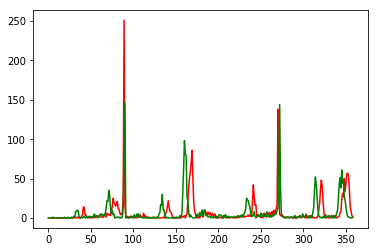

Final result: 
[     7.5247       7.583       7.746      8.1511      7.8967      7.5499      6.9844      9.4071      6.8904      6.7804]


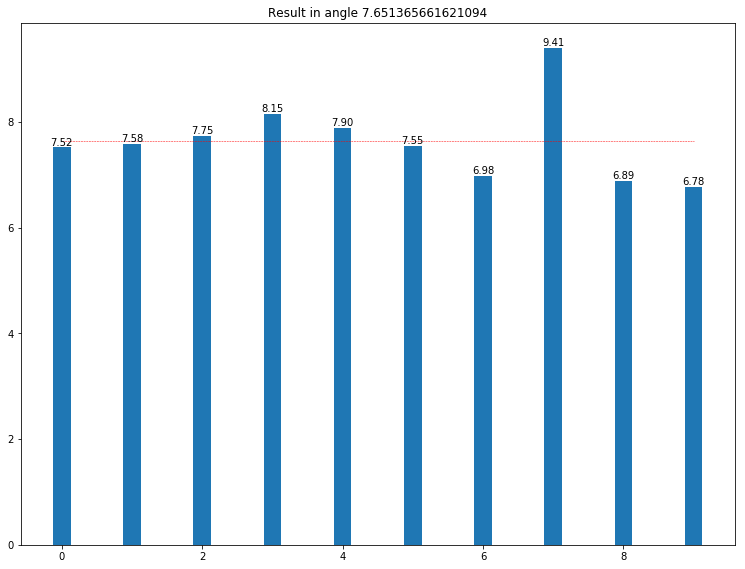

SIFTreal Result: median( 7.651), mean( 7.651) in 0.103


In [2]:
img_base, img_rotate = object_capture(base_file, rotate_file)
histogram_gradient(img_base, img_rotate, mag_thres= 80, bin_num= 360)
median, mean, time = angle_cal(img_base, img_rotate, mode, show_results= show_results, show_images= show_images)
print(mode + "real Result: median({0:6.3f}), mean({1:6.3f}) in {2:.3f}".format(median, mean, time))

In [1]:
for detection_index in range(4):
    img_base, img_rotate = object_capture(base_file, rotate_file,
                       bool_cap = True, detection_index = detection_index,
                       detection_base = detection_base, detection_rotate = detection_rotate)
    histogram_gradient(img_base, img_rotate, mag_thres= 20, bin_num= 360)
    median, mean, time = angle_cal(img_base, img_rotate, mode, show_results= show_results, show_images= show_images)
    print(mode + "real Result: median({0:6.3f}), mean({1:6.3f}) in {2:.3f}".format(median, mean, time))

NameError: name 'object_capture' is not defined